# Testing Out Various Models for Stock Prediction Time Series Analysis

## 1st Model: LSTM Neural Networks

In [5]:
! conda install -y -c conda-forge tensorflow

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 23.5.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /Users/conorsmith/Desktop/practice_projects/env

  added / updated specs:
    - tensorflow


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    abseil-cpp-20211102.0      |       hd638f34_2          13 KB  conda-forge
    c-ares-1.19.1              |       h0dc2134_0         101 KB  conda-forge
    fftw-3.3.10                |nompi_h4fa670e_107         1.7 MB  conda-forge
    google-auth-2.19.0         |     pyh1a96a4e_0          99 KB  conda-forge
   

In [148]:
#standard imports
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np

#tensorflow imports for LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

In [149]:
df = pd.read_csv('sp500_index.csv')
df.head()

,Date,S&P500
0,2012-10-22,1433.82
1,2012-10-23,1413.11
2,2012-10-24,1408.75
3,2012-10-25,1412.97
4,2012-10-26,1411.94


In [150]:
def str_to_datetime(s):
    split = s.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year=year, month=month, day=day)

In [151]:
df['Date'] = df['Date'].apply(str_to_datetime)
df['Date']

0      2012-10-22
1      2012-10-23
2      2012-10-24
3      2012-10-25
4      2012-10-26
          ...    
2512   2022-10-17
2513   2022-10-18
2514   2022-10-19
2515   2022-10-20
2516   2022-10-21
Name: Date, Length: 2517, dtype: datetime64[ns]

In [152]:
df.set_index('Date', inplace=True)
df.head()

,S&P500
Date,
2012-10-22,1433.82
2012-10-23,1413.11
2012-10-24,1408.75
2012-10-25,1412.97
2012-10-26,1411.94


In [153]:
#minmax scaler
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
scaledclose=scaler.fit_transform(np.array(df).reshape(-1,1))

In [154]:
df['Close'] = scaledclose

In [155]:
df_new = df[['Close']]
df_new.head()

,Close
Date,
2012-10-22,0.023376
2012-10-23,0.017362
2012-10-24,0.016095
2012-10-25,0.017321
2012-10-26,0.017022


<AxesSubplot:xlabel='Date'>

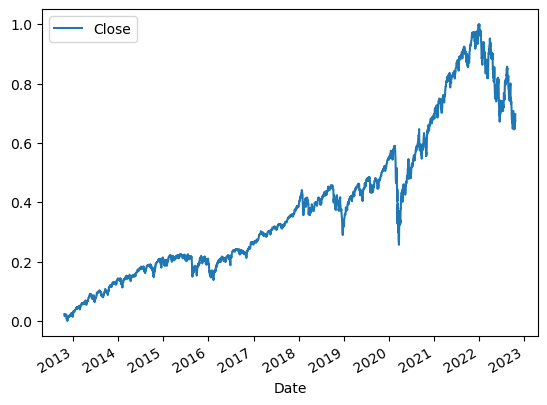

In [156]:
df_new.plot()

In [103]:
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
    first_date = str_to_datetime(first_date_str)

    last_date  = str_to_datetime(last_date_str)

    target_date = first_date
  
    dates = []
    X, Y = [], []

    last_time = False
    while True:
        df_subset = dataframe.loc[:target_date].tail(n+1)
    
        if len(df_subset) != n+1:
            print(f'Error: Window of size {n} is too large for date {target_date}')
            return

        values = df_subset['Close'].to_numpy()
        x, y = values[:-1], values[-1]

        dates.append(target_date)
        X.append(x)
        Y.append(y)

        next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
        next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
        next_date_str = next_datetime_str.split('T')[0]
        year_month_day = next_date_str.split('-')
        year, month, day = year_month_day
        next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
        if last_time:
            break
    
        target_date = next_date

        if target_date == last_date:
            last_time = True
    
    ret_df = pd.DataFrame({})
    ret_df['Target Date'] = dates
  
    X = np.array(X)
    for i in range(0, n):
        X[:, i]
        ret_df[f'Target-{n-i}'] = X[:, i]
  
    ret_df['Target'] = Y

    return ret_df

In [157]:
windowed_df = df_to_windowed_df(df_new, 
                                '2012-10-26', 
                                '2022-03-23', 
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2012-10-26,0.017362,0.016095,0.017321,0.017022
1,2012-10-31,0.016095,0.017321,0.017022,0.017086
2,2012-11-01,0.017321,0.017022,0.017086,0.021567
3,2012-11-02,0.017022,0.017086,0.021567,0.017678
4,2012-11-05,0.017086,0.021567,0.017678,0.018567
...,...,...,...,...,...
2361,2022-03-17,0.818935,0.844881,0.872591,0.888218
2362,2022-03-18,0.844881,0.872591,0.888218,0.903161
2363,2022-03-21,0.872591,0.888218,0.903161,0.902597
2364,2022-03-22,0.888218,0.903161,0.902597,0.917243


In [159]:
df_new.head()

,Close
Date,
2012-10-22,0.023376
2012-10-23,0.017362
2012-10-24,0.016095
2012-10-25,0.017321
2012-10-26,0.017022


In [160]:
def windowed_df_to_date_X_y(windowed_dataframe):
    df_as_np = windowed_dataframe.to_numpy()

    dates = df_as_np[:, 0]

    middle_matrix = df_as_np[:, 1:-1]
    X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

    Y = df_as_np[:, -1]

    return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((2366,), (2366, 3, 1), (2366,))

array([1411.94, 1412.16, 1427.59, ..., 4461.18, 4511.61, 4456.24],
      dtype=float32)

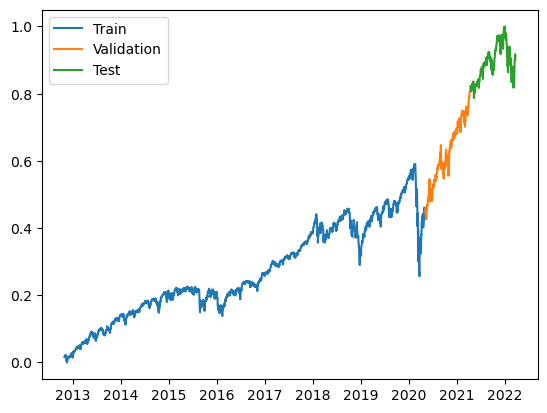

In [161]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [162]:
"""
model = Sequential()
model.add(layers.LSTM(units=50, return_sequences=True, input_shape = (None, 3, 1)))
model.add(layers.LSTM(units=50))
model.add(layers.Dense(1))
"""
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
60/60 [==============================] - 3s 14ms/step - loss: 0.0184 - mean_absolute_error: 0.0997 - val_loss: 0.0104 - val_mean_absolute_error: 0.0972
Epoch 2/100
60/60 [==============================] - 0s 6ms/step - loss: 4.8664e-04 - mean_absolute_error: 0.0144 - val_loss: 2.3037e-04 - val_mean_absolute_error: 0.0122
Epoch 3/100
60/60 [==============================] - 0s 6ms/step - loss: 7.7695e-05 - mean_absolute_error: 0.0055 - val_loss: 1.9240e-04 - val_mean_absolute_error: 0.0107
Epoch 4/100
60/60 [==============================] - 0s 6ms/step - loss: 7.9528e-05 - mean_absolute_error: 0.0056 - val_loss: 1.8811e-04 - val_mean_absolute_error: 0.0104
Epoch 5/100
60/60 [==============================] - 0s 7ms/step - loss: 8.4755e-05 - mean_absolute_error: 0.0058 - val_loss: 2.1724e-04 - val_mean_absolute_error: 0.0118
Epoch 6/100
60/60 [==============================] - 0s 7ms/step - loss: 7.8211e-05 - mean_absolute_error: 0.0056 - val_loss: 2.2981e-04 - val_mean_abso

Epoch 49/100
60/60 [==============================] - 0s 7ms/step - loss: 7.8052e-05 - mean_absolute_error: 0.0058 - val_loss: 3.3770e-04 - val_mean_absolute_error: 0.0157
Epoch 50/100
60/60 [==============================] - 0s 7ms/step - loss: 7.4474e-05 - mean_absolute_error: 0.0055 - val_loss: 1.7381e-04 - val_mean_absolute_error: 0.0100
Epoch 51/100
60/60 [==============================] - 0s 8ms/step - loss: 8.0999e-05 - mean_absolute_error: 0.0060 - val_loss: 2.6045e-04 - val_mean_absolute_error: 0.0133
Epoch 52/100
60/60 [==============================] - 1s 9ms/step - loss: 7.6654e-05 - mean_absolute_error: 0.0057 - val_loss: 2.6014e-04 - val_mean_absolute_error: 0.0134
Epoch 53/100
60/60 [==============================] - 0s 7ms/step - loss: 1.1108e-04 - mean_absolute_error: 0.0077 - val_loss: 2.2405e-04 - val_mean_absolute_error: 0.0122
Epoch 54/100
60/60 [==============================] - 0s 8ms/step - loss: 8.3565e-05 - mean_absolute_error: 0.0060 - val_loss: 2.6000e-04 - 

60/60 [==============================] - 0s 2ms/step


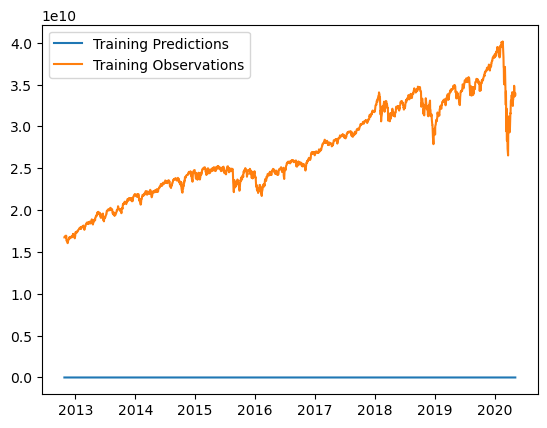

In [144]:
train_predictions = model.predict(X_train)
train_predictions=scaler.inverse_transform(train_predictions)
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

8/8 [==============================] - 0s 4ms/step


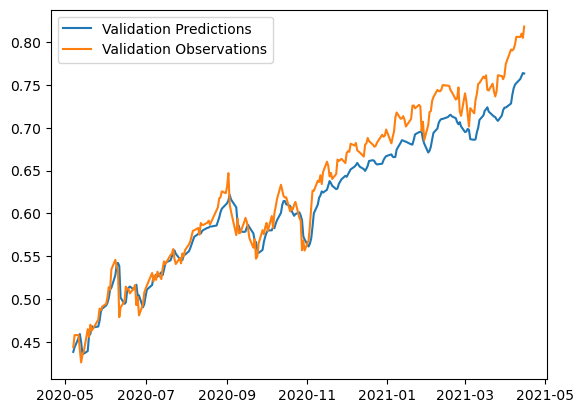

In [133]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

8/8 [==============================] - 0s 4ms/step


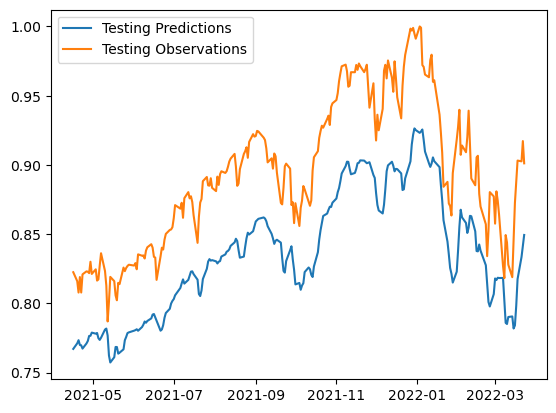

In [134]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

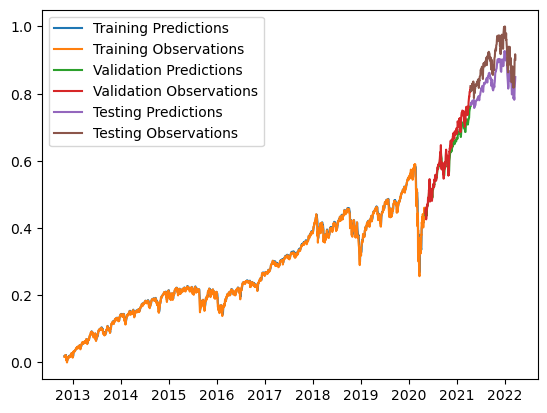

In [114]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])

In [128]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])
last_window = deepcopy(X_train[-1])
for target_date in recursive_dates:
    next_prediction = model.predict(np.array([last_window])).flatten()
    recursive_predictions.append(next_prediction)
    last_window[0] = last_window[1]
    last_window[1] = last_window[-1]
    last_window[-1] = next_prediction
    print(last_window)

1/1 [==============================] - 0s 18ms/step
[[0.43256187]
 [0.44002578]
 [0.43972605]]
1/1 [==============================] - 0s 18ms/step
[[0.44002578]
 [0.43972605]
 [0.44182152]]
1/1 [==============================] - 0s 18ms/step
[[0.43972605]
 [0.44182152]
 [0.4438342 ]]
1/1 [==============================] - 0s 19ms/step
[[0.44182152]
 [0.4438342 ]
 [0.4456198 ]]
1/1 [==============================] - 0s 28ms/step
[[0.4438342 ]
 [0.4456198 ]
 [0.44748566]]
1/1 [==============================] - 0s 29ms/step
[[0.4456198 ]
 [0.44748566]
 [0.44933596]]
1/1 [==============================] - 0s 24ms/step
[[0.44748566]
 [0.44933596]
 [0.4511747 ]]
1/1 [==============================] - 0s 23ms/step
[[0.44933596]
 [0.4511747 ]
 [0.45301104]]
1/1 [==============================] - 0s 31ms/step
[[0.4511747 ]
 [0.45301104]
 [0.45484185]]
1/1 [==============================] - 0s 26ms/step
[[0.45301104]
 [0.45484185]
 [0.4566682 ]]
1/1 [==============================] - 0s 18ms/ste

[[0.5634649 ]
 [0.5636406 ]
 [0.56379855]]
1/1 [==============================] - 0s 25ms/step
[[0.5636406 ]
 [0.56379855]
 [0.5639404 ]]
1/1 [==============================] - 0s 24ms/step
[[0.56379855]
 [0.5639404 ]
 [0.5640677 ]]
1/1 [==============================] - 0s 19ms/step
[[0.5639404 ]
 [0.5640677 ]
 [0.56418216]]
1/1 [==============================] - 0s 21ms/step
[[0.5640677 ]
 [0.56418216]
 [0.5642849 ]]
1/1 [==============================] - 0s 26ms/step
[[0.56418216]
 [0.5642849 ]
 [0.5643772 ]]
1/1 [==============================] - 0s 21ms/step
[[0.5642849 ]
 [0.5643772 ]
 [0.56446016]]
1/1 [==============================] - 0s 24ms/step
[[0.5643772 ]
 [0.56446016]
 [0.56453466]]
1/1 [==============================] - 0s 19ms/step
[[0.56446016]
 [0.56453466]
 [0.56460166]]
1/1 [==============================] - 0s 19ms/step
[[0.56453466]
 [0.56460166]
 [0.56466174]]
1/1 [==============================] - 0s 18ms/step
[[0.56460166]
 [0.56466174]
 [0.56471574]]
1/1 [==

1/1 [==============================] - 0s 25ms/step
[[0.5651926]
 [0.5651926]
 [0.5651926]]
1/1 [==============================] - 0s 26ms/step
[[0.5651926]
 [0.5651926]
 [0.5651926]]
1/1 [==============================] - 0s 20ms/step
[[0.5651926]
 [0.5651926]
 [0.5651926]]
1/1 [==============================] - 0s 23ms/step
[[0.5651926]
 [0.5651926]
 [0.5651926]]
1/1 [==============================] - 0s 25ms/step
[[0.5651926]
 [0.5651926]
 [0.5651926]]
1/1 [==============================] - 0s 27ms/step
[[0.5651926]
 [0.5651926]
 [0.5651926]]
1/1 [==============================] - 0s 29ms/step
[[0.5651926]
 [0.5651926]
 [0.5651926]]
1/1 [==============================] - 0s 26ms/step
[[0.5651926]
 [0.5651926]
 [0.5651926]]
1/1 [==============================] - 0s 26ms/step
[[0.5651926]
 [0.5651926]
 [0.5651926]]
1/1 [==============================] - 0s 30ms/step
[[0.5651926]
 [0.5651926]
 [0.5651926]]
1/1 [==============================] - 0s 27ms/step
[[0.5651926]
 [0.5651926]
 [

1/1 [==============================] - 0s 29ms/step
[[0.5651926]
 [0.5651926]
 [0.5651926]]
1/1 [==============================] - 0s 28ms/step
[[0.5651926]
 [0.5651926]
 [0.5651926]]
1/1 [==============================] - 0s 33ms/step
[[0.5651926]
 [0.5651926]
 [0.5651926]]
1/1 [==============================] - 0s 33ms/step
[[0.5651926]
 [0.5651926]
 [0.5651926]]
1/1 [==============================] - 0s 30ms/step
[[0.5651926]
 [0.5651926]
 [0.5651926]]
1/1 [==============================] - 0s 25ms/step
[[0.5651926]
 [0.5651926]
 [0.5651926]]
1/1 [==============================] - 0s 19ms/step
[[0.5651926]
 [0.5651926]
 [0.5651926]]
1/1 [==============================] - 0s 20ms/step
[[0.5651926]
 [0.5651926]
 [0.5651926]]
1/1 [==============================] - 0s 37ms/step
[[0.5651926]
 [0.5651926]
 [0.5651926]]
1/1 [==============================] - 0s 26ms/step
[[0.5651926]
 [0.5651926]
 [0.5651926]]
1/1 [==============================] - 0s 30ms/step
[[0.5651926]
 [0.5651926]
 [

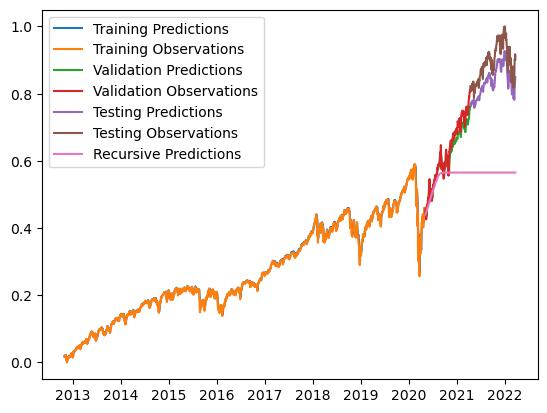

In [129]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations',
            'Recursive Predictions'])